In [ ]:
!pip install langchain langchain-community # text splitters, embeddings, prompt, loaders
!pip install langchain-google-genai # llm
!pip install pypdfium2 # pdf dependency if you are using loaders as PyPDFIUM2
!pip install fastembed # embeddings
!pip install langchain-qdrant # vector database
!pip install opik # tracing and monitoring the entire pipeline
!pip install langgraph

# to upgrade pip install -U opik

- [Qdrant Cloud](https://cloud.qdrant.io/)
- [OPIK API Key](https://www.comet.com/signup?utm_source=workshop&utm_medium=partner&utm_campaign=tarun)

- python3 -m venv env
- source env/bin/activate
- touch requirements.txt
- pip freeze > requirements.txt
- ingest.py: One collection at a time- Only once
- app.py or main.py - real time answer generation (UI)

In [ ]:
import os
from google.colab import userdata

os.environ['OPIK_API_KEY'] = userdata.get("OPIK_API_KEY")
os.environ['OPIK_WORKSPACE'] = "tarun-r-jain"
os.environ['OPIK_PROJECT_NAME'] = "chatbot"
os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')

## Data Ingestion- Offline document processing

In [ ]:
from langchain_community.document_loaders import WebBaseLoader,PyPDFium2Loader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.embeddings.fastembed import FastEmbedEmbeddings
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient,models
from qdrant_client.http.models import Distance, VectorParams

In [ ]:
urls = [
    "https://atyantik.com/",
    "https://atyantik.com/about-us/",
    "https://atyantik.com/software-development-company/",
    "https://atyantik.com/saas-development/",
]

In [ ]:
loader = WebBaseLoader(urls)
documents = loader.load()

In [ ]:
documents[0]

In [ ]:
splitter = RecursiveCharacterTextSplitter(chunk_size=2048, chunk_overlap=0)
docs = splitter.split_documents(documents)

In [ ]:
docs[0].metadata

{'source': 'https://atyantik.com/',
 'title': 'Software Development Company in Vadodara, Gujarat | Atyantik',
 'description': 'Atyantik Technologies provides software, web, and mobile app services in Vadodara, Gujarat. We deliver innovative, scalable, and high-quality IT solutions.',
 'language': 'en-US'}

In [ ]:
embeddings = FastEmbedEmbeddings(model_name = "jinaai/jina-embeddings-v2-base-en") # 768

In [ ]:
len(embeddings.embed_query("hello world"))

768

In [ ]:
url = userdata.get("QDRANT_URL")
api_key = userdata.get("QDRANT_API_KEY")

In [ ]:
client = QdrantClient(
    url = url,
    api_key=api_key,
)

In [ ]:
del documents
import gc
gc.collect()

199

In [ ]:
collection_name = "webpages"

In [ ]:
client.create_collection(
    on_disk_payload=True,
    collection_name = collection_name,
    # dense vector
    vectors_config = models.VectorParams(
        size = 768,
        distance = Distance.COSINE # dense, sparse: TDIDF and BM25
    ),
    # we want to save memory
    quantization_config=models.BinaryQuantization(
        binary = models.BinaryQuantizationConfig(always_ram=False)
    )) # instead of langchain, we will use qrdant functions directly # own metadata -> qdrant

True

- Vectorization: Page Content
- Payload: Metadata or Additional para. Filter your retrieved documents.
- Indexing (Ingestion)
- Search (similarity search, similarity search score, mmr)



In [ ]:
vectorstore = QdrantVectorStore(
    client=client,
    collection_name=collection_name,
    embedding = embeddings
)

In [ ]:
vectorstore.add_documents(docs)

In [ ]:
len(docs)

45

## Answer Generation - RealTime

app.py

In [ ]:
embeddings = FastEmbedEmbeddings(model_name = "jinaai/jina-embeddings-v2-base-en") # 768

In [ ]:
client = QdrantClient(
    url = url,
    api_key=api_key,
)

In [ ]:
collection_name = "webpages"

In [ ]:
# here the data is already present
db = QdrantVectorStore(
    client=client,
    collection_name=collection_name,
    embedding = embeddings
)

In [ ]:
user_query = "how to I contact Atyantik?"
k = 3 # 2000*3 ~ 6000

In [ ]:
test_docs = db.max_marginal_relevance_search(query=user_query,k=k)

In [ ]:
len(test_docs) #[2].page_content

3

# R- Retrieval

In [ ]:
retriever = db.as_retriever(search_type="mmr",search_kwargs={"k":2})

In [ ]:
retriever.invoke("mail to contact atyantik")

[Document(metadata={'source': 'https://atyantik.com/saas-development/', 'title': 'SaaS Development Services | SaaS Development Company', 'description': 'We are top-rated SaaS development company delivering scalable, secure, and innovative SaaS solutions tailored to your needs.', 'language': 'en-US', '_id': '53b8287b-975e-45f1-b91e-658b7dbabc0b', '_collection_name': 'webpages'}, page_content='Atyantik is a team of techno enthusiasts with over a decade of experience delivering IT solutions for clients across diverse industries. At Atyantik, we believe in providing our customers a value-driven, highly professional expertise and offering much more up-to-date technology, time-efficient, and cost-effective solutions.\t\t\t\t\t\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nSite map\nAbout us\nServices\nOur Work\nCareers\n \n\nPartnership\nContact\n \n\nContact\n\n\t\t\t\t\t\t\t501, Privilege Avenue, Dr. Vikram Sarabhai Campus, Atlantis Lane, Beside Tricolor Hospit

## A- Augmentation

In [ ]:
system_prompt = """
You an seasoned employee at Atyantik, who knows about the tech and software industry in-depth.
You should be respectful and truthful while answering the user questions

The only source information you have is the context provided, if the user query is not from the context
Just say `I dont know , not enough information provided.`
"""

In [ ]:
user_prompt = """
Answer the USER QUERY based on the CONTEXT below.
If the question cannot be answered using the information provided answer with `I dont know , not enough information provided.`
<context>
CONTEXT: {context}
</context>

<query>
USER QUERY: {query}
</query>
"""

In [ ]:
from langchain_core.prompts import ChatPromptTemplate

In [ ]:
prompt_template = ChatPromptTemplate(
    messages = [
        ("system",system_prompt),
        ("user",user_prompt)
    ],
)

## G - Generation

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI

In [ ]:
from opik.integrations.langchain import OpikTracer

In [ ]:
opik_tracer = OpikTracer()

In [ ]:
llm = ChatGoogleGenerativeAI(model="gemini-2.5-pro",temperature=0.0,
                             max_tokens=None,callbacks=[opik_tracer])

- LCEL
- LangGraph (preferred): State Management (Graph based)

## LCEL

In [ ]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

In [ ]:
parser = StrOutputParser() # PydanticOutparser

In [ ]:
chain = (
    {"context": retriever, "query": RunnablePassthrough()}
    | prompt_template
    | llm
    | parser
)

In [ ]:
response = chain.invoke({"query":"what is Atyantik product about"},callbacks=[opik_tracer])

In [ ]:
print(response)

Based on the information provided, Atyantik Technologies is a software development company that provides services to build custom software solutions for other businesses, rather than having a single product of its own.

Our expertise lies in partnering with businesses to transform their ideas into reliable software products. We offer a range of services, including:

*   **Custom Software Development:** Creating tailored solutions to solve specific business challenges.
*   **Enterprise Software Solutions:** Building tools like ERP, CRM, and management systems to streamline business operations and improve efficiency.


State:
```
class RAG:
  context: List[str]
  query: str
  answer: str

Node:

def retriever(State):
   context = db.search_tec(state['query'],k=3)

def generate(State):
   answer = llm.invoke(state['query']+state['context'])

Edge
START - Retreiver
Retriever - Generate
Generate - END
```

- LangGraph example
- Vector database custom creation
- Memory utilization for large vectors
- Advance RAG

- Evaluation of the RAG

Project: RFP Generation or any Report Generation
Agentic: Custom tools

12 to 17th: Project Section: Boiler plate or template code. you will have to fill it. 20-30%

UI using Streamlit

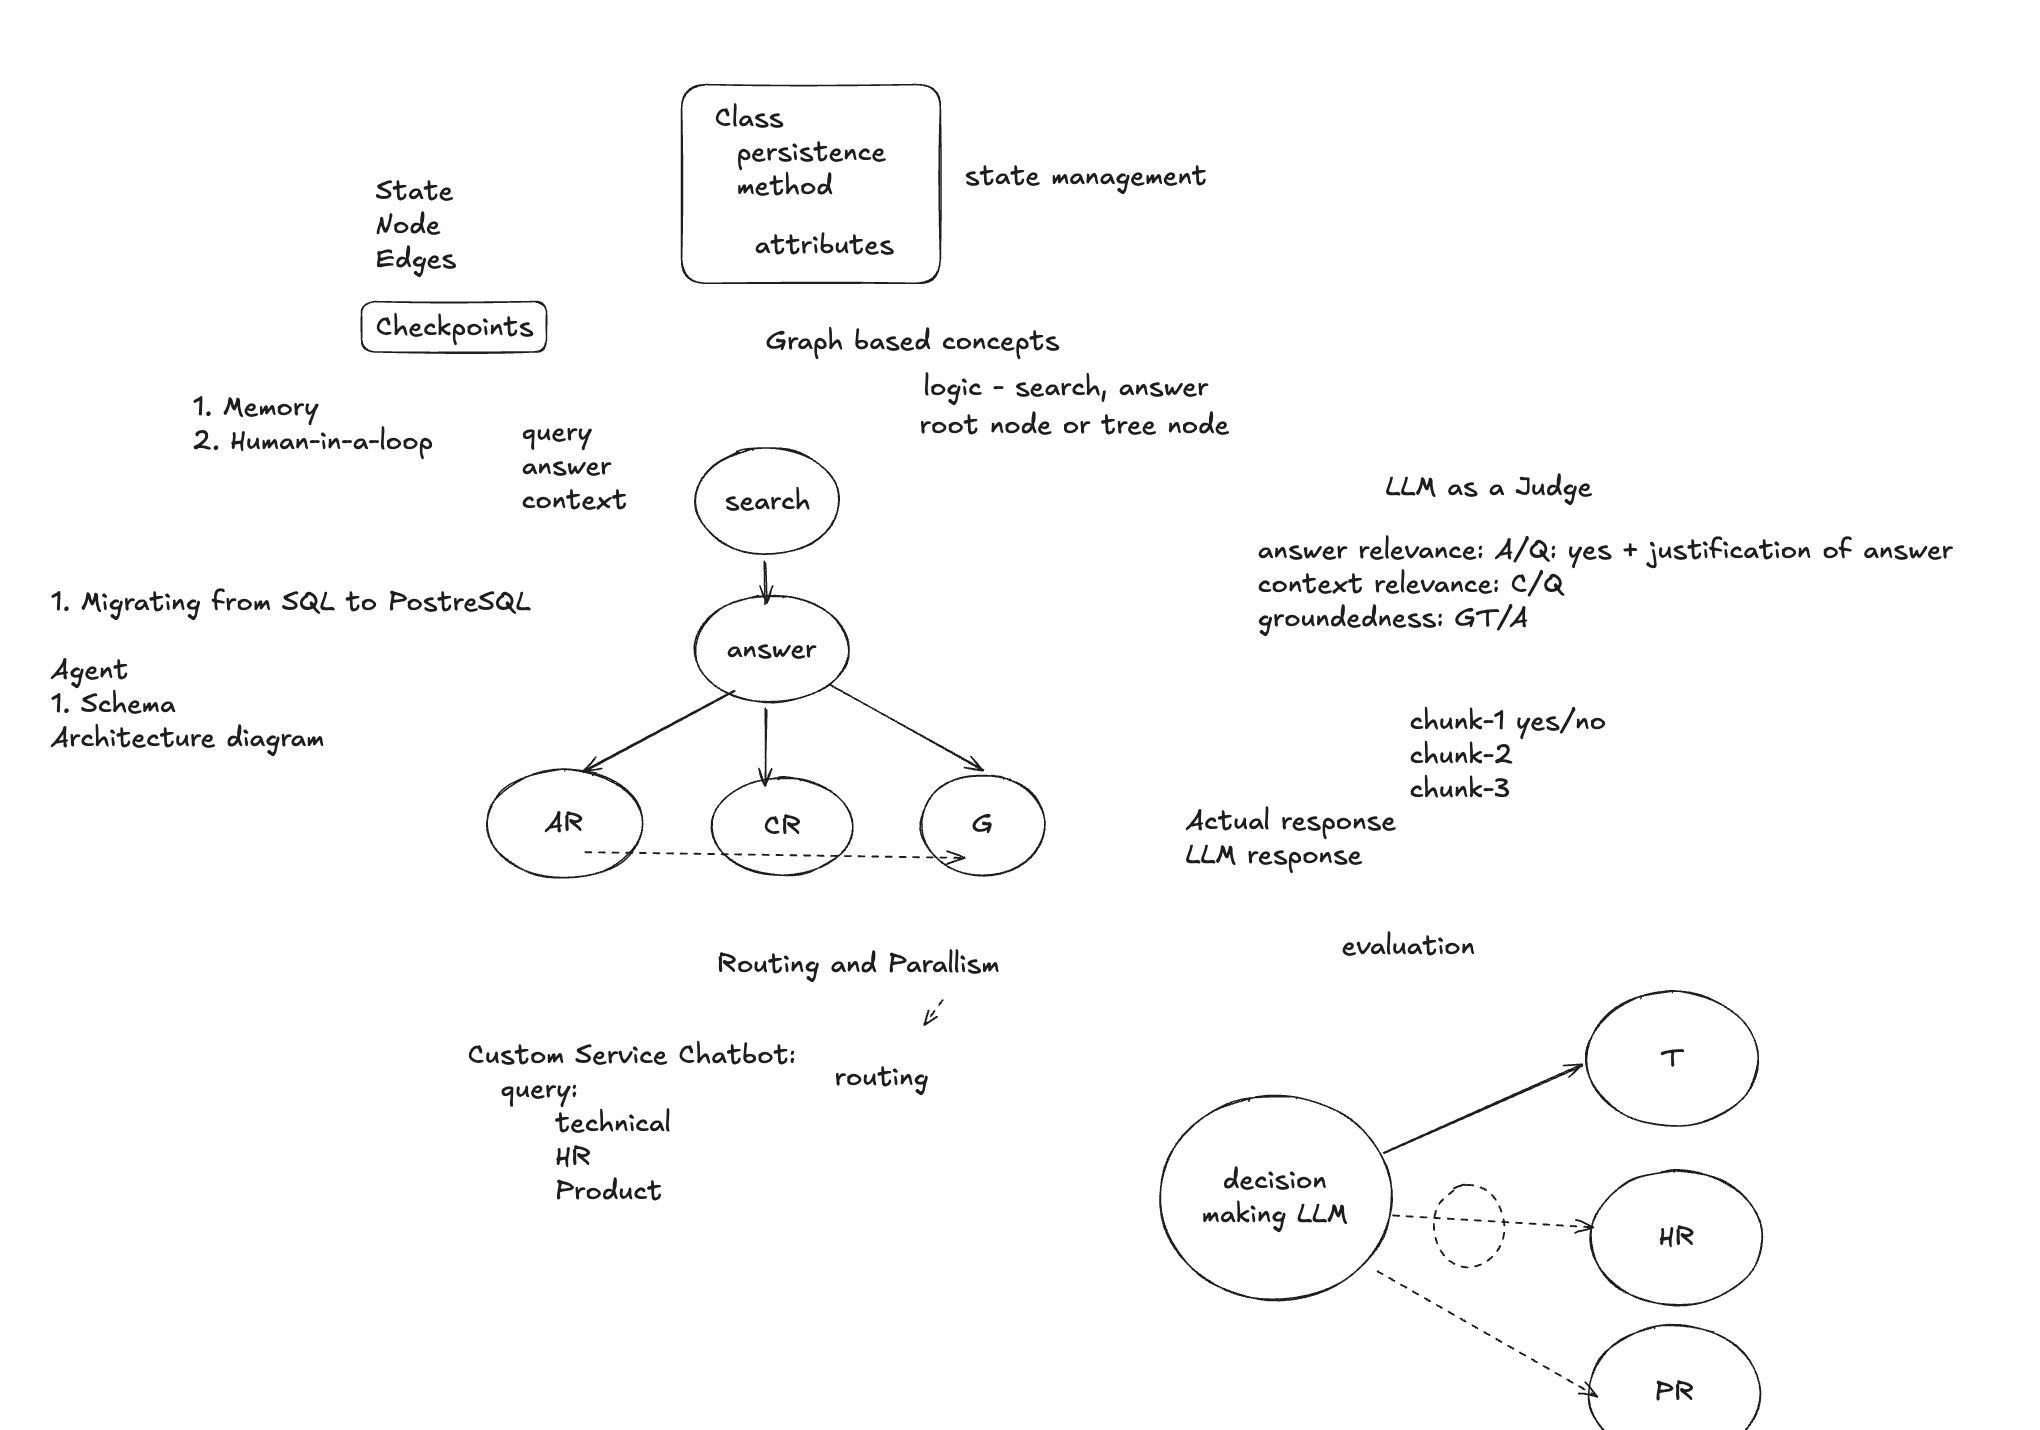

In [ ]:
from langgraph.graph import StateGraph # node and edges logic
from langgraph.graph import START,END
from typing import TypedDict, List

In [ ]:
SYSTEM_PROMPT = """
You an seasoned employee at Atyantik, who knows about the tech and software industry in-depth.
You should be respectful and truthful while answering the user questions

The only source information you have is the context provided, if the user query is not from the context
Just say `I dont know , not enough information provided.`
"""

USER_PROMPT = """
Answer the USER QUERY based on the CONTEXT below. Act as assistant
If the question cannot be answered using the information provided answer with `I dont know , not enough information provided.`
<context>
CONTEXT: {context}
</context>

<query>
USER QUERY: {query}
</query>
"""

In [ ]:
class RAGState(TypedDict):
    query: str
    context: List[str]
    answer: str

def search(state: RAGState) -> RAGState:
    db = QdrantVectorStore(
        client=client,
        collection_name=collection_name, # 768
        embedding = embeddings
    )
    retriever = db.as_retriever(search_type="mmr",
                                search_kwargs={"k":3})
    relevant_docs = retriever.invoke(state['query'])
    context = []
    for doc in relevant_docs:
        context.append(doc.page_content)

    state['context'] = context
    return state

# gpt4o and gpt4.1
def answer(state: RAGState) -> RAGState:
    context = " ".join(state['context']) # converting list to str
    llm = ChatGoogleGenerativeAI(model="gemini-2.5-pro",
                                temperature=0.0,max_tokens=None)
    prompt_template = ChatPromptTemplate(
        messages = [
            ("system",SYSTEM_PROMPT),
            ("user",USER_PROMPT.format(context=context,
                                        query=state['query']))
        ],
    )
    answer = llm.invoke(prompt_template.format_messages())
    state['answer'] = answer.content
    return state

# Agent - workflows
workflow = StateGraph(RAGState)
workflow.add_node("search_context",search)
workflow.add_node("answer_generation",answer)

workflow.add_edge(START,"search_context")
workflow.add_edge("search_context","answer_generation")
workflow.add_edge("answer_generation",END)

graph = workflow.compile()

In [ ]:
from IPython.display import display_markdown

In [ ]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

Graph(nodes={'__start__': Node(id='__start__', name='__start__', data=RunnableCallable(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None), 'search_context': Node(id='search_context', name='search_context', data=search_context(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None), 'answer_generation': Node(id='answer_generation', name='answer_generation', data=answer_generation(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None), '__end__': Node(id='__end__', name='__end__', data=None, metadata=None)}, edges=[Edge(source='__start__', target='search_context', data=None, conditional=False), Edge(source='search_context', target='answer_generation', data=None, conditional=False), Edge(source='answer_generation', target='__end__', data=None, conditional=False)])

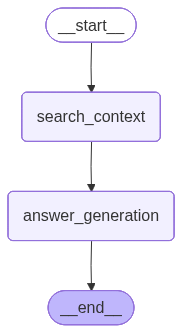

In [ ]:
graph

In [ ]:
response = graph.invoke({"query":"mail to contact atyantik"})

In [ ]:
response['context']

['Atyantik is a team of techno enthusiasts with over a decade of experience delivering IT solutions for clients across diverse industries. At Atyantik, we believe in providing our customers a value-driven, highly professional expertise and offering much more up-to-date technology, time-efficient, and cost-effective solutions.\t\t\t\t\t\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nSite map\nAbout us\nServices\nOur Work\nCareers\n \n\nPartnership\nContact\n \n\nContact\n\n\t\t\t\t\t\t\t501, Privilege Avenue, Dr. Vikram Sarabhai Campus, Atlantis Lane, Beside Tricolor Hospital, Above HDFC Bank, Vadodara, Gujarat 390022, India\t\t\t\t\t\t\n\n\n\n\n\n\t\t\t\t\t\t\t\t+91-8347435435\t\t\t\t\t\t\t\n\n\n\n\n\n\n\n\t\t\t\t\t\t\t\tcontact@atyantik.com\t\t\t\t\t\t\t\n\n\n\n\n\nCopyright Â© 2025 Atyantik Technologies Private Limited\n\n\nPrivacy policy\nTerms and Conditions\nCookie policy',
 "So excited to work with Atyantik, who are engaged in creating our next platfor